In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from timm.models.layers import DropPath
from torchsummary import summary
from lion_pytorch import Lion
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [45]:
train_data = train_data.astype(np.float32)
test_data.iloc[:, 1:] = test_data.iloc[:, 1:].astype(np.float32)
train_data.iloc[:, 0] -= train_data.label.min()
train_data.iloc[:, 1:] = train_data.iloc[:, 1:] / 255
test_data.iloc[:, 1:] = test_data.iloc[:, 1:] / 255

In [46]:
print(f'Min label: {train_data.label.min()}')
print(f'Max label: {train_data.label.max()}')
print(f'Min pixel: {train_data.iloc[:, 1:].min().min()}')
print(f'Max pixel: {train_data.iloc[:, 1:].max().max()}')

Min label: 0.0
Max label: 35.0
Min pixel: 0.0
Max pixel: 1.0


In [47]:
train_data

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_2490,pixel_2491,pixel_2492,pixel_2493,pixel_2494,pixel_2495,pixel_2496,pixel_2497,pixel_2498,pixel_2499
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80208,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80209,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80210,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80211,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
img_tform_1 = transforms.Compose([
    transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean=(0.0253), std=(0.1131))])

img_tform_2 = transforms.Compose([
    transforms.ToPILImage(), transforms.RandomRotation(15), transforms.ToTensor(),
    transforms.Normalize(mean=(0.0253), std=(0.1131))])

img_tform_3 = transforms.Compose([
    transforms.ToPILImage(), transforms.RandomRotation(45), transforms.ToTensor(),
    transforms.Normalize(mean=(0.0253), std=(0.1131))])

img_tform_4 = transforms.Compose([
    transforms.ToPILImage(), transforms.RandomAffine(degrees=20, translate=(0.15, 0.15), scale=(0.85, 0.85)), \
    transforms.ToTensor(), transforms.Normalize(mean=(0.0253), std=(0.1131))])

img_tform_5 = transforms.Compose([
    transforms.ToPILImage(), transforms.RandomAffine(degrees=15, translate=(0.25, 0.25)), \
    transforms.ToTensor(), transforms.Normalize(mean=(0.0253), std=(0.1131))])

img_tform_6 = transforms.Compose([
    transforms.ToPILImage(), transforms.RandomAffine(degrees=5, translate=(0.5, 0.5)), \
    transforms.ToTensor(), transforms.Normalize(mean=(0.0253), std=(0.1131))])

In [49]:
class KyrMnistDataset(Dataset):
    def __init__(self, features, transform=img_tform_1):
        self.features = features.iloc[:, 1:].values.reshape((-1, 50, 50)).astype(np.float32)
        self.targets = torch.from_numpy(features.label.values)
        self.transform = transform

    def __len__(self):
        return (self.features.shape[0])

    def __getitem__(self, idx):
        return self.transform(self.features[idx]), self.targets[idx]

In [50]:
learning_rate = 3e-4
batch_size = 64
seed = 42
num_epochs = 15

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [51]:
def create_dataloaders(seed=seed, validation_size=0.1, df=train_data, batch_size=batch_size):
    train_df, val_df = train_test_split(df, test_size=validation_size, random_state=seed, stratify=df['label'])

    train_data_1 = KyrMnistDataset(train_df)
    train_data_2 = KyrMnistDataset(train_df, img_tform_2)
    train_data_3 = KyrMnistDataset(train_df, img_tform_3)
    train_data_4 = KyrMnistDataset(train_df, img_tform_4)
    train_data_5 = KyrMnistDataset(train_df, img_tform_5)
    train_data_6 = KyrMnistDataset(train_df, img_tform_6)
    train_final = ConcatDataset([train_data_1, train_data_2, train_data_3,
                                 train_data_4, train_data_5, train_data_6])

    val_data = KyrMnistDataset(val_df)

    train_loader = DataLoader(train_final, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, valid_loader

In [52]:
class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format='channels_first'):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == 'channels_last':
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == 'channels_first':
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

In [53]:
class BasicBlock(nn.Module):
    def __init__(self, dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=5, padding=2, groups=dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.norm = LayerNorm(dim, data_format='channels_last')
        self.act = nn.GELU()
        self.drop_path = DropPath(0.2)
        self.gamma = nn.Parameter(1e-6 * torch.ones((dim)),
                                  requires_grad=True)

    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = self.gamma * x
        x = x.permute(0, 3, 1, 2)
        x = res + self.drop_path(x)
        return x

In [54]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),

            LayerNorm(64),
            nn.Conv2d(64, 64, kernel_size=2, stride=2),

            BasicBlock(64),
            BasicBlock(64),
            BasicBlock(64),

            LayerNorm(64),
            nn.Conv2d(64, 128, kernel_size=2, stride=2),

            BasicBlock(128),
            BasicBlock(128),
            BasicBlock(128),
            BasicBlock(128),
            BasicBlock(128),
            BasicBlock(128),
            BasicBlock(128),
            BasicBlock(128),
            BasicBlock(128),

            LayerNorm(128),
            nn.Conv2d(128, 256, kernel_size=2, stride=2),

            BasicBlock(256)
        )

        self.avgpool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256, 36)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=2e-2)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = self.classifier(x)

        return x


model = Model()
model.to(device);

In [55]:
print(summary(model, (1, 50, 50)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
         LayerNorm-2           [-1, 64, 48, 48]             128
            Conv2d-3           [-1, 64, 24, 24]          16,448
            Conv2d-4           [-1, 64, 24, 24]           1,664
         LayerNorm-5           [-1, 24, 24, 64]             128
            Linear-6          [-1, 24, 24, 256]          16,640
              GELU-7          [-1, 24, 24, 256]               0
            Linear-8           [-1, 24, 24, 64]          16,448
          DropPath-9           [-1, 64, 24, 24]               0
       BasicBlock-10           [-1, 64, 24, 24]               0
           Conv2d-11           [-1, 64, 24, 24]           1,664
        LayerNorm-12           [-1, 24, 24, 64]             128
           Linear-13          [-1, 24, 24, 256]          16,640
             GELU-14          [-1, 24, 

In [56]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device, epoch):
    model.train()
    final_loss = 0
    train_acc = 0
    total = 0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, ncols=120)
    loop.set_description(f'Epoch: [{epoch + 1}/{num_epochs}]')
    for batch_idx, (features, labels) in loop:
        inputs, targets = features.to(device, non_blocking=True), labels.to(device, non_blocking=True).long()

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        for param in model.parameters():
            param.grad = None
        model.zero_grad(set_to_none=True)
        optimizer.zero_grad(set_to_none=True)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total += len(targets)
        final_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_acc += ((predicted == targets).sum().item())
        if batch_idx % 200 == 0:
            loop.update()
            loop.set_postfix(loss=f'{final_loss / (batch_idx + 1):.5f}', acc=f'{train_acc / total:.5f}')

    final_loss /= len(dataloader)
    train_acc = (train_acc / total) * 100

    return final_loss, train_acc


def valid_fn(model, loss_fn, dataloader, device, epoch, best_result):
    model.eval()
    final_loss = 0
    val_acc = 0
    total = 0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for batch_idx, (features, labels) in loop:
        inputs, targets = features.to(device, non_blocking=True), labels.to(device, non_blocking=True).long()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        total += len(targets)
        final_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_acc += ((predicted == targets).sum().item())
        loop.set_description(f'Epoch: [{epoch + 1}/{num_epochs}]')
        loop.set_postfix(loss=final_loss / (batch_idx + 1), acc=val_acc / total)

    final_loss /= len(dataloader)
    val_acc = (val_acc / total) * 100

    if val_acc > best_result:
        name = 'best_models/model_v' + str(epoch + 1) + '.pth'
        torch.save(model.state_dict(), name)
        best_result = val_acc
    return final_loss, val_acc, best_result

In [57]:
weights = train_data.copy()
weights['count_of_targets'] = weights['label'].map(weights['label'].value_counts())
weights.sort_values('label', inplace=True)
weights.drop_duplicates('label', inplace=True)
n_samples = list(weights['count_of_targets'])
weights = [(max(n_samples) / n) for n in n_samples]
loss_weights = torch.FloatTensor(weights).to(device)
loss_weights

tensor([1.1653, 1.1611, 1.1685, 1.1658, 1.1637, 1.1564, 1.1798, 1.1798, 1.1538,
        1.1616, 1.1334, 1.1648, 1.1137, 1.1611, 1.1590, 1.0051, 1.1669, 1.0000,
        1.1749, 1.1680, 1.1722, 1.1658, 1.3991, 1.0020, 1.1658, 1.1669, 1.1765,
        1.1225, 1.1685, 1.1674, 1.1653, 1.1658, 1.1653, 1.1658, 1.1690, 1.1374],
       device='cuda:0')

In [58]:
def run_training(seed, train_acc_lst, train_loss_lst, val_acc_lst, val_loss_lst):
    train_loader, valid_loader = create_dataloaders(seed=seed)
    best_result = 0

    optimizer = Lion(model.parameters(), lr=learning_rate, weight_decay=3e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=num_epochs, eta_min=3e-4)
    loss_fn = nn.CrossEntropyLoss(weight=loss_weights)
    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
      
        train_loss, train_acc = train_fn(model, optimizer, scheduler, loss_fn, train_loader, device, epoch)
     
        train_acc_lst.append(train_acc)
      
        train_loss_lst.append(train_loss)
     
        val_loss, val_acc, best_result = valid_fn(model, loss_fn, valid_loader, device, epoch, best_result)

        val_acc_lst.append(val_acc)
      
        val_loss_lst.append(val_loss)
     

In [59]:
train_acc_lst = []
train_loss_lst = []
val_acc_lst = []
val_loss_lst = []
# run_training(seed, train_acc_lst, train_loss_lst, val_acc_lst, val_loss_lst)

In [60]:
model = Model()
model.load_state_dict(torch.load('model_v11.pth'))
model.eval()

Model(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): LayerNorm()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
      (pwconv1): Linear(in_features=64, out_features=256, bias=True)
      (pwconv2): Linear(in_features=256, out_features=64, bias=True)
      (norm): LayerNorm()
      (act): GELU(approximate='none')
      (drop_path): DropPath(drop_prob=0.200)
    )
    (4): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
      (pwconv1): Linear(in_features=64, out_features=256, bias=True)
      (pwconv2): Linear(in_features=256, out_features=64, bias=True)
      (norm): LayerNorm()
      (act): GELU(approximate='none')
      (drop_path): DropPath(drop_prob=0.200)
    )
    (5): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), pa

tensor(28)


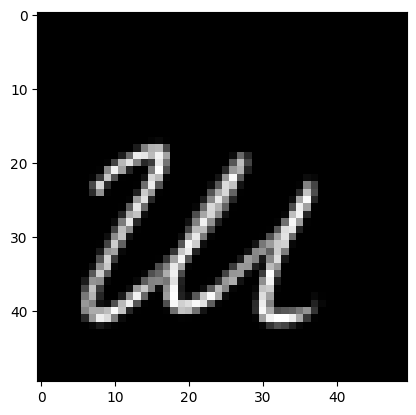

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv("test.csv")


first_column = df.iloc[:, 1:2502]

image_data = first_column.values.reshape((len(df), 50, 50))
tensor_data = torch.tensor(image_data[6788], dtype=torch.float32)
normalize = transforms.Normalize(mean=[0.485], std=[0.229])
tensor_data = tensor_data.view(1, 1, 50, 50)
tensor_data = normalize(tensor_data)
ans = model(tensor_data)
print(torch.argmax(ans))

first_column = df.iloc[:, 1:2502]

image_data = first_column.values.reshape((len(df), 50, 50))
plt.imshow(image_data[6788], cmap='gray') 
plt.show()